Goal of this notebook: 

- explore DICOMDIR data using Python
- export to ParaView and do something with it

# Readings

## People who have done this before

http://pythology.blogspot.fr/2017/01/visualize-your-dicom-ct-scan-in-3d-with.html


https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/



http://bastian.rieck.ru/blog/posts/2014/dicom_utilities/


## Python packages

Pydicom


## Other

Paraview can read .dcm files.

But not DICOMDIR headers. 

ITK could, but it needicomdir to be installed.

GDCM is an implementation of DICOM that has Python wrappers.

[this page](http://dicomiseasy.blogspot.fr/2013/03/dicomdir-and-media-interchange.html) explains how DICOM works.

# Exploring the data 

## The header 

In [1]:
import dicom

In [2]:
dicomdir = dicom.read_dicomdir()

There's quite a lot of stuff in here.

In [3]:
dicomdir.DirectoryRecordSequence

<Sequence, length 120, at 628E6D8>

What sort of nodes do we have?

In [4]:
set([record.DirectoryRecordType for record in dicomdir.DirectoryRecordSequence])

{'IMAGE', 'PATIENT', 'SERIES', 'STUDY'}

Let's count the instances of each.

In [5]:
from collections import Counter

In [6]:
Counter([record.DirectoryRecordType for record in dicomdir.DirectoryRecordSequence])

Counter({'IMAGE': 112, 'PATIENT': 1, 'SERIES': 6, 'STUDY': 1})

Let's just print the patient, study and series items.

In [7]:
for record in dicomdir.DirectoryRecordSequence:
    if record.DirectoryRecordType == 'PATIENT':
        print(record)

(0004, 1400) Offset of the Next Directory Record UL: 0
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 530
(0004, 1430) Directory Record Type               CS: 'PATIENT'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0010, 0010) Patient's Name                      PN: 'LE BOURDAIS^Florian'
(0010, 0020) Patient ID                          LO: '337572.780873'


In [8]:
for record in dicomdir.DirectoryRecordSequence:
    if record.DirectoryRecordType == 'STUDY':
        print(record)

(0004, 1400) Offset of the Next Directory Record UL: 0
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 752
(0004, 1430) Directory Record Type               CS: 'STUDY'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0020) Study Date                          DA: '20170502'
(0008, 0030) Study Time                          TM: '174509.720000'
(0008, 0050) Accession Number                    SH: '337572.14859'
(0008, 1030) Study Description                   LO: 'MEMBRE INF^GENOU'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3680043.2.406.337572.20171
(0020, 0010) Study ID                            SH: '337572.14859'


In [9]:
for record in dicomdir.DirectoryRecordSequence:
    if record.DirectoryRecordType == 'SERIES':
        print(record)

(0004, 1400) Offset of the Next Directory Record UL: 1738
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 934
(0004, 1430) Directory Record Type               CS: 'SERIES'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'localizer_tra'
(0020, 000e) Series Instance UID                 UI: 1.3.12.2.1107.5.2.40.50164.2017050217460712059466888.0.0.0
(0020, 0011) Series Number                       IS: '1'
(0004, 1400) Offset of the Next Directory Record UL: 8370
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 1924
(0004, 1430) Directory Record Type               CS: 'SERIES'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description          

So I have six series.

In [10]:
series = [record for record in dicomdir.DirectoryRecordSequence if record.DirectoryRecordType == 'SERIES']

How do I know the links between the series? I can just query their children!

In [11]:
for serie in series:
    print(serie.SeriesDescription, len(serie.children), "images")

localizer_tra 3 images
localizer 3 PLANS 11 images
SAG DP FS . 24 images
CORO DP FS 22 images
AX DP FS . 28 images
SAG T1 24 images


## Individual image 

As a first step, I want to just be able to read a single image, for which I can get the raw data.

In [12]:
child_records = [record for record in series[0].children]

In [13]:
len(child_records)

3

In [14]:
record = child_records[0]

In [15]:
record

(0004, 1400) Offset of the Next Directory Record UL: 1202
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 0
(0004, 1430) Directory Record Type               CS: 'IMAGE'
(0004, 1500) Referenced File ID                  CS: ['IMAGES', 'IM00002']
(0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage
(0004, 1511) Referenced SOP Instance UID in File UI: 1.3.12.2.1107.5.2.40.50164.2017050217461498337266901
(0004, 1512) Referenced Transfer Syntax UID in F UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'M', 'NORM', 'DIS2D']
(0020, 0013) Instance Number                     IS: '2'

In [16]:
child_records[1]

(0004, 1400) Offset of the Next Directory Record UL: 1470
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 0
(0004, 1430) Directory Record Type               CS: 'IMAGE'
(0004, 1500) Referenced File ID                  CS: ['IMAGES', 'IM00000']
(0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage
(0004, 1511) Referenced SOP Instance UID in File UI: 1.3.12.2.1107.5.2.40.50164.2017050217461287636966893
(0004, 1512) Referenced Transfer Syntax UID in F UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'M', 'NORM', 'DIS2D']
(0020, 0013) Instance Number                     IS: '3'

In [17]:
child_records[2]

(0004, 1400) Offset of the Next Directory Record UL: 0
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 0
(0004, 1430) Directory Record Type               CS: 'IMAGE'
(0004, 1500) Referenced File ID                  CS: ['IMAGES', 'IM00001']
(0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage
(0004, 1511) Referenced SOP Instance UID in File UI: 1.3.12.2.1107.5.2.40.50164.2017050217461356040866897
(0004, 1512) Referenced Transfer Syntax UID in F UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'M', 'NORM', 'DIS2D']
(0020, 0013) Instance Number                     IS: '1'

In [18]:
[record.InstanceNumber for record in child_records]

['2', '3', '1']

Now how do I get the raw data? I should be able to save it to a file and read it. See here: <http://stackoverflow.com/questions/10129717/how-access-to-a-single-numpy-array-in-a-dicomdir-file-with-pydicom>.

In [19]:
import os
for record in child_records:
    if record.DirectoryRecordType == "IMAGE":
    # Extract the relative path to the DICOM file
        path = os.path.join(*record.ReferencedFileID)
        dcm = dicom.read_file(path)

This issue says that I can just save the PixelData to a file <https://github.com/darcymason/pydicom/issues/213>

In [20]:
with open('extraction_test.jpg', 'wb') as f:
    f.write(dcm.PixelData)

## Converting the data 

This doesn't work: I need a reader that knows that format. Let's try with gdcmconv <http://gdcm.sourceforge.net/html/gdcmconv.html>.

In [25]:
import glob

In [30]:
filenames = [fname for fname in glob.glob('IMAGES/IM*') if not fname.endswith('.raw')]

In [32]:
filenames[:10]

['IMAGES\\IM00000',
 'IMAGES\\IM00001',
 'IMAGES\\IM00002',
 'IMAGES\\IM00003',
 'IMAGES\\IM00004',
 'IMAGES\\IM00005',
 'IMAGES\\IM00006',
 'IMAGES\\IM00007',
 'IMAGES\\IM00008',
 'IMAGES\\IM00009']

There's a trick to integrate Python stuff into the shell command found here: <https://www.safaribooksonline.com/blog/2014/02/12/using-shell-commands-effectively-ipython/>.

In [33]:
for fname in filenames:
    !gdcmconv.exe -i {fname} -o {fname + '.raw'} --raw

Cool, now I have converted all my files to raw files. I can now build 3D datasets.

## Building datasets 

Let's now build a dataset with this. I follow the Pyscience blog: <https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/>.

I just want to keep the images of one series so I have to filter these filenames.

In [51]:
int(child_records[0].InstanceNumber)

1

In [39]:
child_records = [record for record in series[3].children]
len(child_records)

22

And I have to sort them by instance number.

In [58]:
child_records = sorted(child_records, key=lambda r: int(r.InstanceNumber))

In [59]:
raw_filenames = ["\\".join(record.RefdFileID) + ".raw" for record in child_records]

Now I can read them and make a big array.

In [61]:
RefDs = dicom.read_file(raw_filenames[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(raw_filenames))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [62]:
ConstPixelDims

(384, 384, 22)

In [63]:
ConstPixelSpacing

(0.44270834326744, 0.44270834326744, 3.0)

Now I can create a grid.

In [65]:
import numpy as np

In [66]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [72]:
x.shape

(385,)

In [73]:
y.shape

(385,)

In [74]:
ArrayDicom.shape

(384, 384, 22)

In [69]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in raw_filenames:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, raw_filenames.index(filenameDCM)] = ds.pixel_array  

Finally, I can save this array to a file.

In [70]:
from evtk.hl import gridToVTK 

In [76]:
gridToVTK('datasets/dataset', x, y, z, cellData={'IRM': ArrayDicom})

'C:\\Users\\FL232714\\Documents\\Perso\\IRM\\datasets\\dataset.vtr'

Let's also build the other datasets.

In [85]:
def build_dataset(serie, outputfname):
    "Builds a vtk dataset from a given series with its children images."
    child_records = [record for record in serie.children]
    child_records = sorted(child_records, key=lambda r: int(r.InstanceNumber))
    raw_filenames = ["\\".join(record.RefdFileID) + ".raw" for record in child_records]
    RefDs = dicom.read_file(raw_filenames[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(raw_filenames))
    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in raw_filenames:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, raw_filenames.index(filenameDCM)] = ds.pixel_array  
        
        

    gridToVTK(outputfname, x, y, z, cellData={'IRM': ArrayDicom})

In [86]:
build_dataset(series[0], "datasets/dataset_0")

In [87]:
build_dataset(series[1], "datasets/dataset_1")

In [88]:
build_dataset(series[2], "datasets/dataset_2")

In [89]:
build_dataset(series[3], "datasets/dataset_3")

In [90]:
build_dataset(series[4], "datasets/dataset_4")

In [91]:
build_dataset(series[5], "datasets/dataset_5")

## Investigating the histogram of the data 

Credits for the approach here:

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

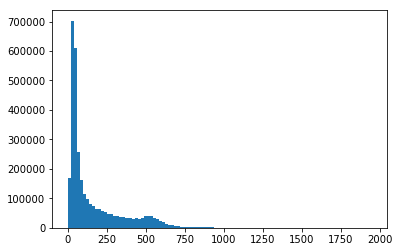

In [80]:
plt.hist(ArrayDicom.ravel(), bins=100);

Let's display one of the slices I have with a lot of bone.

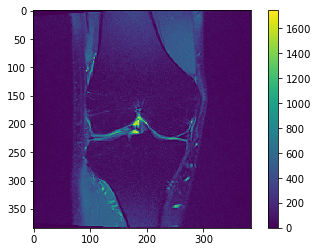

In [82]:
plt.imshow(ArrayDicom[:, :, 11])
plt.colorbar()

## Segmenting the dataset using scikit-image 